In [18]:

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats


In [11]:
from esmvalcore.dataset import Dataset

In [12]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
"ERA-Interim": 
    Dataset(
    short_name='tos',
    dataset='ERA-Interim',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20190101",
    tier=3)
}

In [13]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [14]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [15]:
def prepoc1(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = area_statistics(cube,operator='mean')
    cube = extract_month(cube,12) # get DEC
    return cube

def prepoc2(cube):
    pac_region = {"start_longitude": 140., "end_longitude": 260., "start_latitude": -1., "end_latitude": 1.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **pac_region)
    cube = anomalies(cube,period='monthly')
    cube = extract_month(cube,12) # get DEC
    cube = axis_statistics(cube,axis='y', operator='mean')
    return cube

In [16]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}


In [19]:
model_nino34 = model_datasets_prep1["ACCESS-ESM1-5"].data
model_ssta = model_datasets_prep2["ACCESS-ESM1-5"].data
model_lon = model_datasets_prep2["ACCESS-ESM1-5"].coord('longitude').points

# Transpose ssta_data to match the shape required for linregress
model_ssta_transposed = model_ssta.T  # Shape becomes (120, 36)

# Initialize an array to store the slope values for each spatial point
model_slope = np.zeros(model_ssta_transposed.shape[0])  # Length will be 120

# Loop over the 120 spatial points (after transpose, each row is a time series)
for i in range(model_ssta_transposed.shape[0]):
    # Perform linear regression between the transposed data and nino34_data
    model_slope[i], model_intercept, model_r_value, model_p_value, model_std_err = scipy.stats.linregress(model_ssta_transposed[i], model_nino34)


In [20]:
obs_nino34 = obs_datasets_prep1["HadISST"].data
obs_ssta = obs_datasets_prep2["HadISST"].data
obs_lon = obs_datasets_prep2["HadISST"].coord('longitude').points

# Transpose ssta_data to match the shape required for linregress
obs_ssta_transposed = obs_ssta.T  # Shape becomes (120, 36)

# Initialize an array to store the slope values for each spatial point
obs_slope = np.zeros(obs_ssta_transposed.shape[0])  # Length will be 120

# Loop over the 120 spatial points (after transpose, each row is a time series)
for i in range(obs_ssta_transposed.shape[0]):
    # Perform linear regression between the transposed data and nino34_data
    obs_slope[i], obs_intercept, obs_r_value, obs_p_value, obs_std_err = scipy.stats.linregress(obs_ssta_transposed[i], obs_nino34)


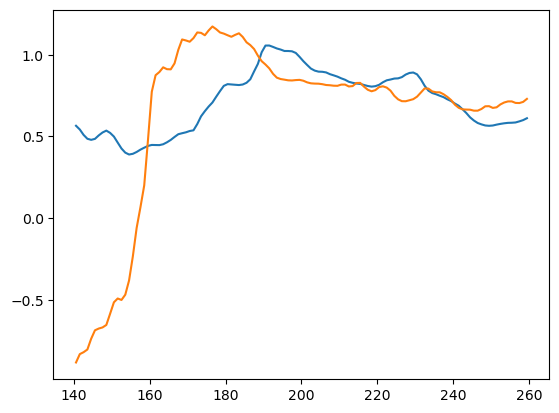

In [21]:
# Now slope will be an array of length 120
plt.plot(model_lon, model_slope)
plt.plot(obs_lon, obs_slope)

In [57]:
import numpy as np
import scipy.stats

# Assuming ssta_data has dimensions (time, latitude, longitude)
# Flatten the spatial dimensions (latitude, longitude) to apply regression on each point
ssta_data_reshaped = ssta_data.reshape(ssta_data.shape[0], -1)  # Shape will be (time, latitude*longitude)
nino34_data_reshaped = np.squeeze(nino34_data)  # Shape (time,)

# Ensure matching lengths
if ssta_data_reshaped.shape[0] != nino34_data_reshaped.shape[0]:
    raise ValueError("Shapes of ssta_data and nino34_data do not match.")

# Initialize arrays to store the regression results
slope_2d = np.full(ssta_data_reshaped.shape[1], np.nan)

# Calculate regression coefficient (slope) for each spatial point
for i in range(ssta_data_reshaped.shape[1]):
    # Perform regression on the flattened spatial point
    ssta_point = ssta_data_reshaped[:, i]

    # Check if all values in ssta_point are identical or if the data is not valid for regression
    if np.all(ssta_point == ssta_point[0]) or np.all(np.isnan(ssta_point)):
        slope_2d[i] = np.nan  # Assign NaN for points with identical or invalid values
    else:
        try:
            # Perform linear regression for each point
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ssta_point, nino34_data_reshaped)
            slope_2d[i] = slope  # Store the slope
        except ValueError:
            slope_2d[i] = np.nan  # Handle regression failure (e.g., due to insufficient data)

# Reshape slope_2d back to the original spatial dimensions (50, 120)
slope_2d_reshaped = slope_2d.reshape(ssta_data.shape[1], ssta_data.shape[2])

# Output the shapes to confirm
print("Slope (Regression Coefficient) shape:", slope_2d_reshaped.shape)
print("Slope (Regression Coefficient):", slope_2d_reshaped)


Slope (Regression Coefficient) shape: (10, 120)
Slope (Regression Coefficient): [[0.16827881        nan        nan ... 0.72528986 0.72189154 0.72089646]
 [0.69004153 0.65395897        nan ... 0.70282718 0.6992435  0.69363828]
 [0.74505182 0.77520143 0.74124915 ... 0.65342689 0.65449209 0.6483174 ]
 ...
 [0.75259705 0.75116037 0.75102675 ... 0.79048184 0.80689143 0.81735047]
 [0.72204746 0.71544237 0.71737381 ... 0.91262354 0.91452323 0.91307102]
 [0.45560451 0.45803243 0.47326292 ... 0.95329085 0.95546281 0.95417939]]


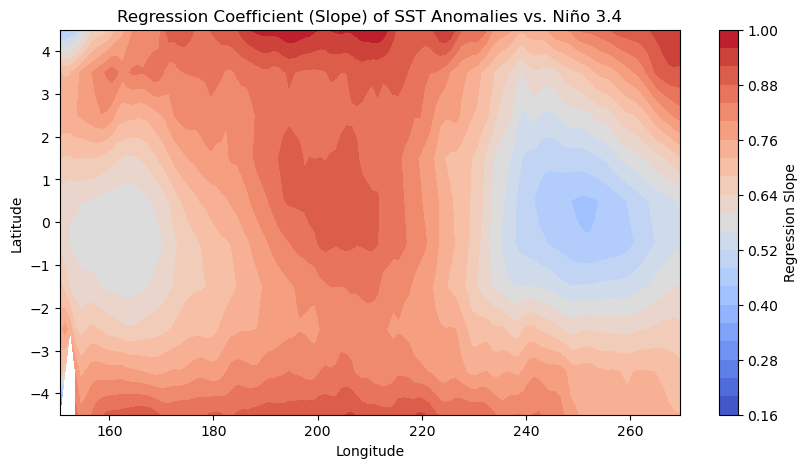

In [58]:
# Assuming you have access to the latitude and longitude arrays
# Example: lat and lon are arrays corresponding to the dimensions of ssta_data
# lat and lon should have shapes (latitude,) and (longitude,) respectively

# Example latitude and longitude arrays
# Replace these with actual data from your dataset
lat = ssta.coord('latitude').points
lon = ssta.coord('longitude').points

# Ensure that lat and lon match the dimensions of your slope_2d_reshaped
if len(lat) != slope_2d_reshaped.shape[0] or len(lon) != slope_2d_reshaped.shape[1]:
    raise ValueError("Latitude or Longitude dimensions do not match slope dimensions.")

# Create the contour plot
plt.figure(figsize=(10, 5))
contour = plt.contourf(lon, lat, slope_2d_reshaped, cmap='coolwarm', levels=20)
plt.colorbar(contour, label='Regression Slope')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Regression Coefficient (Slope) of SST Anomalies vs. Niño 3.4')
plt.show()


# Select December

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

# Assuming model_datasets_prep1 and model_datasets_prep2 are your data containers
nino34 = model_datasets_prep1["ACCESS-ESM1-5"]
ssta = model_datasets_prep2["ACCESS-ESM1-5"]

# Extract the time coordinate from ssta and nino34
time_ssta = ssta.coord('time')
time_nino34 = nino34.coord('time')


In [129]:
import iris
import pandas as pd
import numpy as np

# Assuming 'ssta' is an iris cube
time_coord = ssta.coord('time')
time_points = time_coord.points

# Extract units from the time coordinate
units = time_coord.units
units_str = str(units)  # Convert the Unit object to a string

# Extract reference date
reference_date_str = units_str.split(' since ')[1]
reference_date = pd.to_datetime(reference_date_str)

# Convert time_points to datetime
dates = reference_date + pd.to_timedelta(time_points, unit='D')

# Filter for December
december_dates = dates[dates.month == 12]

print("December Dates:", december_dates)


December Dates: DatetimeIndex(['1979-12-16 12:00:00', '1980-12-16 12:00:00',
               '1981-12-16 12:00:00', '1982-12-16 12:00:00',
               '1983-12-16 12:00:00', '1984-12-16 12:00:00',
               '1985-12-16 12:00:00', '1986-12-16 12:00:00',
               '1987-12-16 12:00:00', '1988-12-16 12:00:00',
               '1989-12-16 12:00:00', '1990-12-16 12:00:00',
               '1991-12-16 12:00:00', '1992-12-16 12:00:00',
               '1993-12-16 12:00:00', '1994-12-16 12:00:00',
               '1995-12-16 12:00:00', '1996-12-16 12:00:00',
               '1997-12-16 12:00:00', '1998-12-16 12:00:00',
               '1999-12-16 12:00:00', '2000-12-16 12:00:00',
               '2001-12-16 12:00:00', '2002-12-16 12:00:00',
               '2003-12-16 12:00:00', '2004-12-16 12:00:00',
               '2005-12-16 12:00:00', '2006-12-16 12:00:00',
               '2007-12-16 12:00:00', '2008-12-16 12:00:00',
               '2009-12-16 12:00:00', '2010-12-16 12:00:00',
        

In [158]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew

# Assuming ssta is an iris cube
time_coord = ssta.coord('time')
time_points = time_coord.points

# Extract units from the time coordinate
units = time_coord.units
units_str = str(units)  # Convert the Unit object to a string

# Extract reference date
reference_date_str = units_str.split(' since ')[1]
reference_date = pd.to_datetime(reference_date_str)

# Convert time_points to datetime
dates = reference_date + pd.to_timedelta(time_points, unit='D')

# Filter for December
december_dates = dates[dates.month == 12]
december_indices = np.where(dates.month == 12)[0]

# Subset the ssta cube for December entries
ssta_december = ssta[december_indices]

# Compute the mean along the 'time' dimension
ssta_december_mean = ssta_december.collapsed('time', iris.analysis.MEAN)

ssta_december_std = np.std(ssta_december.data, axis=0)  # Compute std deviation along the 'time' axis
ssta_december_skew = skew(ssta_december.data, axis=0, nan_policy='omit')  # Compute skewness along the 'time' axis


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(


In [164]:
# Extract data and coordinates
data = ssta_december_skew  # NumPy array
lat = ssta_december_mean.coord('latitude').points
lon = ssta_december_mean.coord('longitude').points


/jobfs/124990957.gadi-pbs/ipykernel_1745860/3884449779.py:7: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='SST Anomalies')


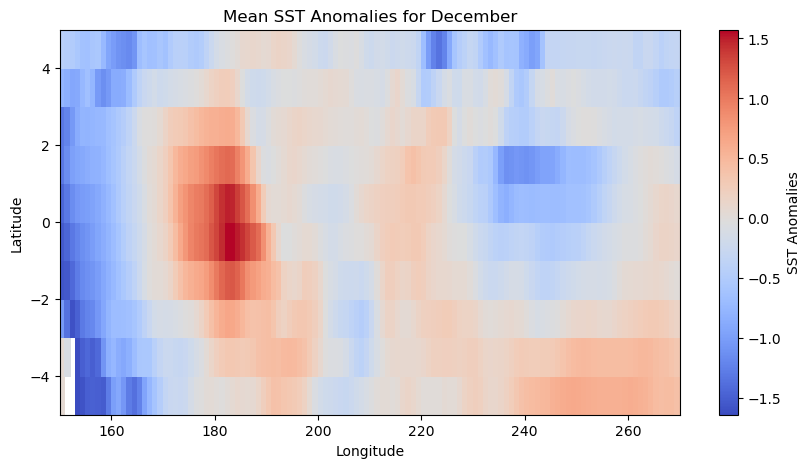

In [166]:
# Create a meshgrid for plotting
lon2D, lat2D = np.meshgrid(lon, lat)

# Plotting using pcolor
plt.figure(figsize=(10, 5))
plt.pcolor(lon2D, lat2D, data, cmap='coolwarm', shading='auto')
plt.colorbar(label='SST Anomalies')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mean SST Anomalies for December')
plt.show()

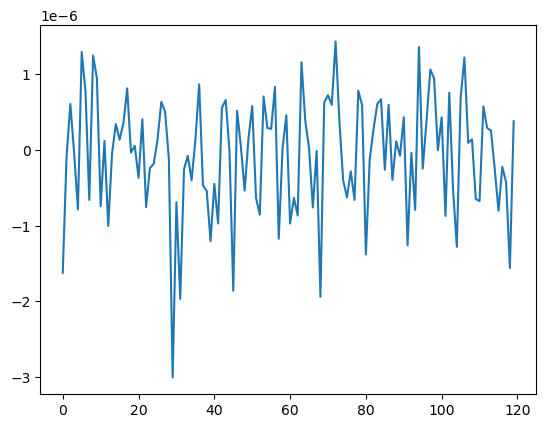

In [177]:
data_mean_meridional = np.mean(ssta_december_mean.data, axis=0)
plt.plot( data_mean_meridional )
